# Credit Card Fraud Detection: A Systematic Evaluation of Sampling Strategies

**Date:** November 2025  
**Aim:** Build the best possible fraud detection model through systematic experimentation with sampling techniques and comparison of gradient boosting frameworks  
**Dataset:** https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

---

## Executive Summary

This notebook documents a rigorous machine learning pipeline for credit card fraud detection, achieving **0.9020 AUPRC** (Area Under Precision-Recall Curve) through systematic evaluation of sampling strategies and ensemble methods. This work builds upon previous undergraduate research conducted in MATLAB (https://github.com/Dyllaan/MLP-ANN) with substantially improved methodology and experimental rigor.

### Key Findings

**Best Model Performance:**
- **Optimal Configuration**: SMOTE 0.02 + XGBoost → **0.9020 AUPRC**
- Precision: 0.876 | Recall: 0.867
- Improvement over no-sampling baseline: +0.70% relative improvement (+0.63 percentage points)
- The modest improvement suggests XGBoost's native class imbalance handling via `scale_pos_weight` is already highly effective for most applications

**Sampling Strategy Insights:**
- **SMOTE (2-3% ratio)** achieves optimal performance with +0.70% AUPRC improvement over baseline
- **Borderline SMOTE** demonstrates competitive performance at 0.9010 AUPRC
- **No-sampling baseline** achieves 0.8957 AUPRC, demonstrating XGBoost's inherent strength on tabular data
- **ADASYN** shows inconsistent results across sampling ratios. Despite theoretical advantages in difficult-to-learn regions, ADASYN underperforms likely due to: (1) unreliable distance metrics in PCA-transformed feature space, and (2) amplification of noisy borderline cases, degrading generalization
- **SMOTE-ENN** significantly reduces precision (0.67-0.79), making it unsuitable for production deployment

**Model Comparison:**
- **XGBoost** consistently outperforms LightGBM across all sampling strategies
- **LightGBM** achieves marginally higher recall (0.898) but lower precision
- Further hyperparameter tuning may reduce this performance gap
- XGBoost demonstrates greater stability and robustness across different sampling ratios

### Methodology

**Dataset:**
- Source: Kaggle Credit Card Fraud Detection
- Size: 284,807 transactions
- Features: 30 (28 PCA-transformed + Time + Amount)
- Class imbalance: 0.17% fraud (577:1 ratio)

**Approach:**
1. **Feature Engineering**: Statistical aggregations, time-based patterns, and interaction features derived from highest-importance features
2. **Baseline Models**: XGBoost and LightGBM with `scale_pos_weight` for class imbalance
3. **Sampling Techniques**: SMOTE, ADASYN, Borderline SMOTE, SMOTE-ENN
4. **Hyperparameter Optimization**: Bayesian optimization (50 trials, 5-fold cross-validation)
5. **Evaluation**: AUPRC, Precision, Recall on held-out test set

### Why AUPRC over ROC-AUC?

For highly imbalanced datasets, **AUPRC is the superior metric** because:
- Focuses exclusively on minority class (fraud) detection performance
- More sensitive to false positives and false negatives in imbalanced scenarios
- Better represents real-world operational performance
- ROC-AUC can be misleadingly optimistic for rare event detection

### Performance Trade-offs

**Precision vs Recall:**
- **High Precision**: SMOTE 0.03 XGBoost (0.896 precision), minimising false alarms and customer friction
- **High Recall**: No-sampling LightGBM (0.898 recall), maximises fraud detection at cost of more investigations
- **Balanced**: SMOTE 0.02 XGBoost (0.876 precision, 0.867 recall) gives optimal overall performance

**Business Implications:**
- High precision reduces operational costs and improves customer experience
- High recall minimises financial losses from undetected fraud
- Optimal threshold depends on organization-specific cost structure

### Future Work

- Neural network architectures warrant further investigation, though preliminary experiments indicated higher computational costs with inferior performance compared to gradient boosting methods
- Deep learning approaches may require substantially larger datasets or different feature representations to match boosting performance on this tabular data

---

## Data Loading and Train/Test Split

I use an 80/20 train-test split with stratification to maintain class balance. Additionally, I create a validation set (20% of training data) for:
- Feature engineering validation
- Hyperparameter tuning without touching the test set
- Preventing data leakage

This three-way split ensures the test set remains a true held-out set for final evaluation.

In [1]:
from cache_manager import CacheManager
from dataset_manager import DatasetManager
from sklearn.model_selection import train_test_split

cache_manager = CacheManager('cache')
random_state = 222

dm = DatasetManager('creditcard.csv')
X_train_raw, X_test_raw, y_train, y_test = dm.create_train_test_split(test_size=0.2, random_state=random_state)

# Split training data into train/validation for feature engineering
X_train_inner, X_val, y_train_inner, y_val = train_test_split(
    X_train_raw, 
    y_train,
    test_size=0.2,
    random_state=random_state,
    stratify=y_train
)

print(f"Data splits:")
print(f"  Training (inner): {X_train_inner.shape[0]} samples")
print(f"  Validation:       {X_val.shape[0]} samples")
print(f"  Test (held-out):  {X_test_raw.shape[0]} samples")

Loaded dataset from creditcard.csv
Dataset Shape: (284807, 31)
Dataset Shape: (284807, 31)

Column Names:
['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']

Class Distribution:
Class
0    284315
1       492
Name: count, dtype: int64

Fraud Rate: 0.173%
Imbalance Ratio: 1:577
Train Set:
  Total: 227,845
  Frauds: 394
  Fraud rate: 0.173%

Test Set:
  Total: 56,962
  Frauds: 98
  Fraud rate: 0.172%

Stratification preserved the class distribution
Data splits:
  Training (inner): 182276 samples
  Validation:       45569 samples
  Test (held-out):  56962 samples


## Feature Engineering

Feature engineering is critical for fraud detection. I apply:
- **Statistical features**: Mean, standard deviation, minimum, maximum aggregations
- **Time-based features**: Transaction patterns over time windows
- **Amount-based features**: Normalised and binned transaction amounts
- **Interaction features**: Combinations of existing features

The engineer is fitted on training data and transforms validation and test sets to prevent data leakage.

In [2]:
from feature_engineer import FeatureEngineer

# Feature engineering using train/validation
engineer = FeatureEngineer(cache_manager=cache_manager, random_state=random_state)
X_train_eng, X_val_eng, results = engineer.fit_transform(
    X_train_inner, y_train_inner,
    X_val, y_val,
    top_n_engineer=5,
    prune_thresh=0.005,
    use_cache=True
)

# Apply transformations to test set
X_test_eng = engineer.transform(X_test_raw)


Loaded cached features
  Cache key: 9e48e61b0caf9641bb64619a5cf7fd69
  Location:  cache\features\features_9e48e61b0caf9641bb64619a5cf7fd69.pkl
  Train:     (182276, 54)
  Test:      (45569, 54)
  Features:  54
Loaded from cache
  Features: 54
  Top 5: ['Top5_std', 'Top5_min', 'V11', 'V4_V12', 'V14_div_V4']

Applying learned transformations to new data...

Engineering from: ['V14', 'V4', 'V13', 'V23', 'V12']
Created 41 new features → 71 total
Transformed: 56962 samples × 54 features


## Baseline Models (No Sampling)

I establish baseline performance using XGBoost and LightGBM **without any sampling techniques**.

Both models use:
- `scale_pos_weight` to handle class imbalance
- Optimisation using Optuna with 50 trials for hyperparameter tuning
- 5-fold cross-validation for robust evaluation

**Key Question**: Can sampling techniques improve upon these baselines?

In [3]:
from samplers import NoSampler
from orchestrator import run_model

n_trials = 50
n_folds = 5

sampler = NoSampler()
data_tag = 'no_sampling'

results = {}
for model_type in ['xgb', 'lgbm']:
    result_key = f'{data_tag}_{model_type}'
    results[result_key] = run_model(
        model_type, sampler, X_train_eng, y_train_inner,
        X_test_eng, y_test, cache_manager, data_tag, 
        n_trials, n_folds, random_state,
        X_val_raw=X_val_eng, y_val=y_val
    )

print("\nResults:")
for key, value in results.items():
    print(f"  {key}: {value}")

c:\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Configuration: Sampling=None, scale_pos_weight=577.65, eval_on=validation+test


Loaded cached study for XGBoost

Best CV AUPRC: 0.8375

Best Parameters:
  n_estimators        : 772
  max_depth           : 6
  learning_rate       : 0.05894026132718142
  subsample           : 0.876680193290377
  colsample_bytree    : 0.8737717301925384
  min_child_weight    : 11
  gamma               : 2.489731056591925
  reg_alpha           : 0.2108325557996204
  reg_lambda          : 0.015688677947530327
  max_delta_step      : 4
  scale_pos_weight: 577.65
Loaded cached model

XGBoost Validation AUPRC: 0.8413
XGBoost Validation Precision: 0.8800
XGBoost Validation Recall: 0.8354

XGBoost Test AUPRC: 0.8957
XGBoost Test Precision: 0.8776
XGBoost Test Recall: 0.8776

Configuration: Sampling=None, scale_pos_weight=577.65, eval_on=validation+test


Loaded cached study for LightGBM

Best CV AUPRC: 0.8329

Best Parameters:
  n_estimators        : 802
  max_depth           : 7
  num_leaves          : 56
  le

## SMOTE (Synthetic Minority Over-sampling Technique)

SMOTE generates synthetic fraud examples by interpolating between existing fraud cases.

**Ratios tested**: 0.5%, 1%, 2%, 3% fraud representation
- Too little oversampling may not provide sufficient benefit
- Too much oversampling can introduce noise and overfitting

I test multiple ratios to identify the optimal balance for performance.

In [4]:
from orchestrator import SamplingOrchestrator
from samplers import SMOTESampler
over_ratios = [0.005, 0.01, 0.02, 0.03]  # 0.5%, 1%, 2%, 3% fraud

smote_orch = SamplingOrchestrator(SMOTESampler, 'smote', requires_ratio=True)
smote_orch.run_sampling(
    X_train_eng, y_train_inner,
    X_test_eng, y_test,
    cache_manager, 
    n_trials, 
    n_folds, 
    random_state, 
    ratios=over_ratios,
    X_val_raw=X_val_eng, y_val=y_val
)
smote_results = smote_orch.get_results()
print("\nResults:")
for key, value in smote_results.items():
    print(f"  {key}: {value}")

Configuration: Sampling=SMOTE_0.005:1, scale_pos_weight=577.65, eval_on=validation+test


Loaded cached study for XGBoost

Best CV AUPRC: 0.8381

Best Parameters:
  n_estimators        : 443
  max_depth           : 10
  learning_rate       : 0.065548016897522
  subsample           : 0.8525563949028276
  colsample_bytree    : 0.7161009311638927
  min_child_weight    : 7
  gamma               : 1.2793500407240008
  reg_alpha           : 0.38275786569411924
  reg_lambda          : 0.11562558429289213
  max_delta_step      : 3
  scale_pos_weight: 200.18
Loaded cached model

XGBoost Validation AUPRC: 0.8398
XGBoost Validation Precision: 0.9000
XGBoost Validation Recall: 0.7975

XGBoost Test AUPRC: 0.8903
XGBoost Test Precision: 0.8673
XGBoost Test Recall: 0.8673

Configuration: Sampling=SMOTE_0.005:1, scale_pos_weight=577.65, eval_on=validation+test


Loaded cached study for LightGBM

Best CV AUPRC: 0.8418

Best Parameters:
  n_estimators        : 442
  max_depth           : 8
  num_leaves 

## ADASYN (Adaptive Synthetic Sampling)

ADASYN is theoretically an improvement over SMOTE that focuses on generating synthetic samples in harder-to-learn regions.

**Key difference from SMOTE**:
- Generates more synthetic samples near the decision boundary
- Adapts to the density distribution of the minority class
- Potentially better at capturing edge cases

**Expectation**: Should perform similarly or slightly better than SMOTE due to adaptive placement of synthetic samples.

In [5]:
from samplers import ADASYNSampler

adasyn_orch = SamplingOrchestrator(ADASYNSampler, 'adasyn', requires_ratio=True)
adasyn_orch.run_sampling(
    X_train_eng, y_train_inner,
    X_test_eng, y_test,
    cache_manager, 
    n_trials, 
    n_folds, 
    random_state, 
    ratios=over_ratios,
    X_val_raw=X_val_eng, y_val=y_val
)

adasyn_results = adasyn_orch.get_results()
print("\nResults:")
print('\n'.join(f"  {k}: {v}" for k, v in adasyn_results.items()))

Configuration: Sampling=ADASYN_0.005:1, scale_pos_weight=577.65, eval_on=validation+test


Loaded cached study for XGBoost

Best CV AUPRC: 0.8338

Best Parameters:
  n_estimators        : 484
  max_depth           : 9
  learning_rate       : 0.0851825387881024
  subsample           : 0.7173378539711038
  colsample_bytree    : 0.7858725427863422
  min_child_weight    : 14
  gamma               : 1.3505161044734135
  reg_alpha           : 6.120447697884591
  reg_lambda          : 9.851701678355825
  max_delta_step      : 2
  scale_pos_weight: 204.68
Loaded cached model

XGBoost Validation AUPRC: 0.8262
XGBoost Validation Precision: 0.7927
XGBoost Validation Recall: 0.8228

XGBoost Test AUPRC: 0.8945
XGBoost Test Precision: 0.7982
XGBoost Test Recall: 0.8878

Configuration: Sampling=ADASYN_0.005:1, scale_pos_weight=577.65, eval_on=validation+test


Loaded cached study for LightGBM

Best CV AUPRC: 0.8345

Best Parameters:
  n_estimators        : 515
  max_depth           : 8
  num_leaves  

## Borderline SMOTE

Borderline SMOTE only generates synthetic samples near the decision boundary (borderline cases).

**Rationale**:
- Focus on the most challenging examples
- Avoid adding redundant samples in easy-to-classify regions
- More targeted than standard SMOTE

**Ratios tested**: 0.5%, 1%, 2% (fewer ratios as this approach is more aggressive)

In [6]:
from samplers import BorderlineSMOTESampler

borderline_ratios = [0.005, 0.01, 0.02]  # 0.5%, 1%, 2%

borderline_smote_orch = SamplingOrchestrator(BorderlineSMOTESampler, 'borderline_smote', requires_ratio=True)
borderline_smote_orch.run_sampling(
    X_train_eng, y_train_inner,
    X_test_eng, y_test,
    cache_manager, 
    n_trials, 
    n_folds, 
    random_state, 
    ratios=borderline_ratios,
    X_val_raw=X_val_eng, y_val=y_val
)

borderline_smote_results = borderline_smote_orch.get_results()
print("\nResults:")
for key, value in borderline_smote_results.items():
    print(f"  {key}: {value}")

Configuration: Sampling=BorderlineSMOTE_0.005:1, scale_pos_weight=577.65, eval_on=validation+test


Loaded cached study for XGBoost

Best CV AUPRC: 0.8391

Best Parameters:
  n_estimators        : 798
  max_depth           : 6
  learning_rate       : 0.063431378543785
  subsample           : 0.7240784809034407
  colsample_bytree    : 0.6636873940332197
  min_child_weight    : 8
  gamma               : 3.102876742479156
  reg_alpha           : 0.046032835970165435
  reg_lambda          : 5.188693456920307
  max_delta_step      : 6
  scale_pos_weight: 200.18
Loaded cached model

XGBoost Validation AUPRC: 0.8481
XGBoost Validation Precision: 0.8553
XGBoost Validation Recall: 0.8228

XGBoost Test AUPRC: 0.9010
XGBoost Test Precision: 0.8687
XGBoost Test Recall: 0.8776

Configuration: Sampling=BorderlineSMOTE_0.005:1, scale_pos_weight=577.65, eval_on=validation+test


Loaded cached study for LightGBM

Best CV AUPRC: 0.8393

Best Parameters:
  n_estimators        : 307
  max_depth           

## Light SMOTE-ENN (SMOTE + Edited Nearest Neighbours)

SMOTE-ENN combines oversampling with undersampling:
1. **SMOTE**: Generate synthetic minority samples
2. **ENN**: Remove samples whose class differs from the majority of their neighbours

**Trade-off**:
- Cleaner decision boundaries by removing noisy samples
- Risk of removing too many legitimate samples
- Can significantly reduce precision
- Particularly problematic for highly imbalanced datasets (577:1 ratio) where removing even a small percentage of minority class samples substantially reduces the already limited fraud examples available for training

I use a "light" version to minimise aggressive sample removal, though results suggest even conservative cleaning may be detrimental for this dataset.

In [7]:
from samplers import LightSMOTEENNSampler

smote_enn_ratios = [0.005, 0.01, 0.02]

light_smote_enn_orch = SamplingOrchestrator(LightSMOTEENNSampler, 'light_smote_enn', requires_ratio=True)
light_smote_enn_orch.run_sampling(
    X_train_eng, y_train_inner,
    X_test_eng, y_test,
    cache_manager, 
    n_trials, 
    n_folds, 
    random_state, 
    ratios=smote_enn_ratios,
    X_val_raw=X_val_eng, y_val=y_val
)
light_smote_enn_results = light_smote_enn_orch.get_results()
print("\nResults:")
print('\n'.join(f"  {k}: {v}" for k, v in light_smote_enn_results.items()))

Configuration: Sampling=LightSMOTEENN_0.01:1, scale_pos_weight=577.65, eval_on=validation+test


Loaded cached study for XGBoost

Best CV AUPRC: 0.8229

Best Parameters:
  n_estimators        : 644
  max_depth           : 9
  learning_rate       : 0.09977880695679445
  subsample           : 0.8167869293016394
  colsample_bytree    : 0.7678139182839672
  min_child_weight    : 11
  gamma               : 1.941724851482514
  reg_alpha           : 0.11897837509673148
  reg_lambda          : 0.9192912974592755
  max_delta_step      : 9
  scale_pos_weight: 199.82
Loaded cached model

XGBoost Validation AUPRC: 0.8459
XGBoost Validation Precision: 0.7619
XGBoost Validation Recall: 0.8101

XGBoost Test AUPRC: 0.8825
XGBoost Test Precision: 0.8190
XGBoost Test Recall: 0.8776

Configuration: Sampling=LightSMOTEENN_0.01:1, scale_pos_weight=577.65, eval_on=validation+test


Loaded cached study for LightGBM

Best CV AUPRC: 0.8309

Best Parameters:
  n_estimators        : 869
  max_depth           : 7

## Results Visualisation and Analysis

### AUPRC (Area Under Precision-Recall Curve)

AUPRC is the primary metric because:
- **Focuses on fraud detection performance** (minority class)
- More informative than ROC-AUC for imbalanced datasets
- Captures precision-recall trade-off across all thresholds

**Analysis focus**:
- Which sampling strategy improves AUPRC the most?
- Do complex sampling methods outperform simple baselines?
- Is there a clear winner or is performance similar across methods?

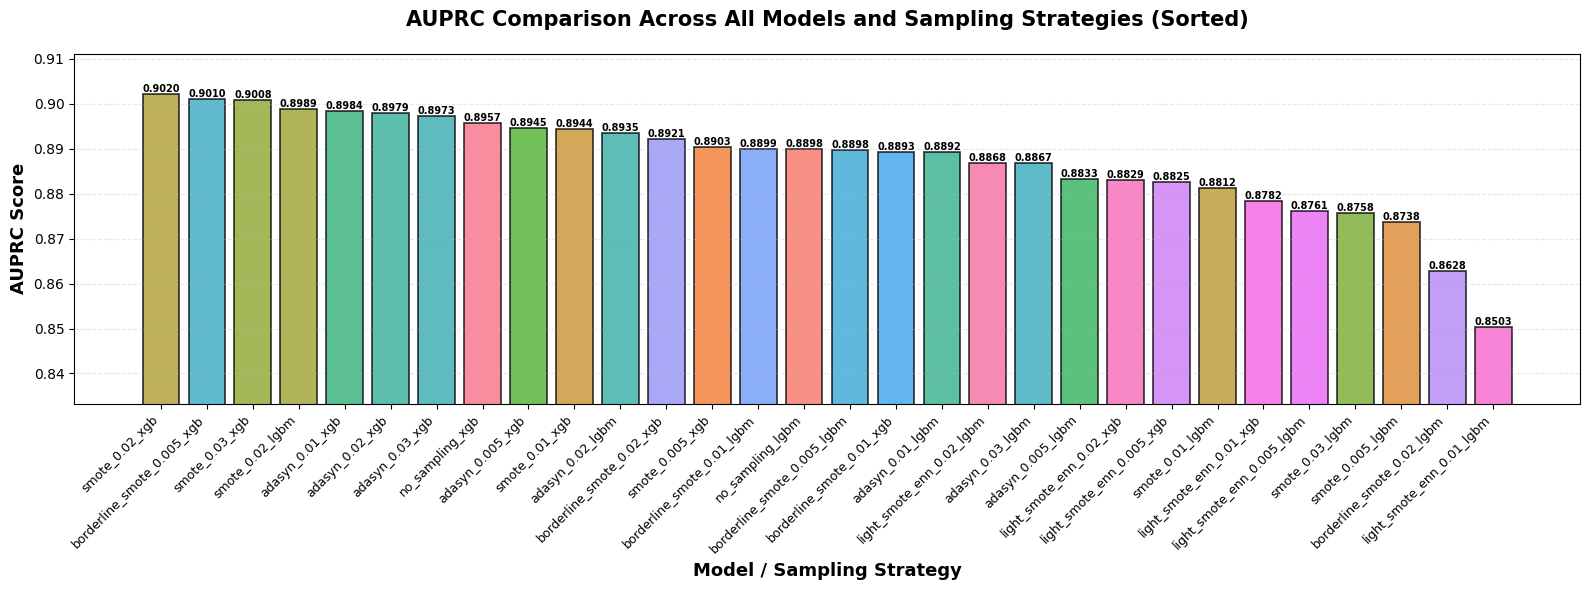

In [ ]:
# Comprehensive Results Visualization - AUPRC
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Combine all results
all_results = {
    **results,
    **smote_results,
    **adasyn_results,
    **borderline_smote_results,
    **light_smote_enn_results
}
# Extract test metrics from results
models = list(all_results.keys())
auprc_scores = []
precision_scores = []
recall_scores = []

for model_name in models:
    result_dict = all_results[model_name]
    # Extract test metrics
    test_auprc = [v for k, v in result_dict.items() if 'test_auprc' in k][0]
    test_precision = [v for k, v in result_dict.items() if 'test_precision' in k][0]
    test_recall = [v for k, v in result_dict.items() if 'test_recall' in k][0]
    
    auprc_scores.append(test_auprc)
    precision_scores.append(test_precision)
    recall_scores.append(test_recall)

# AUPRC Comparison
plt.figure(figsize=(16, 6))
sorted_indices_auprc = np.argsort(auprc_scores)[::-1]  # Descending order
sorted_models_auprc = [models[i] for i in sorted_indices_auprc]
sorted_auprc = [auprc_scores[i] for i in sorted_indices_auprc]
colors_auprc = [sns.color_palette("husl", len(models))[i] for i in sorted_indices_auprc]

bars1 = plt.bar(range(len(sorted_models_auprc)), sorted_auprc, color=colors_auprc, alpha=0.8, edgecolor='black', linewidth=1.2)
plt.xlabel('Model / Sampling Strategy', fontsize=13, fontweight='bold')
plt.ylabel('AUPRC Score', fontsize=13, fontweight='bold')
plt.title('AUPRC Comparison Across All Models and Sampling Strategies (Sorted)', fontsize=15, fontweight='bold', pad=20)
plt.xticks(range(len(sorted_models_auprc)), sorted_models_auprc, rotation=45, ha='right', fontsize=9)
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.ylim([min(sorted_auprc) * 0.98, max(sorted_auprc) * 1.01])

# Add value labels on bars
for i, (bar, score) in enumerate(zip(bars1, sorted_auprc)):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{score:.4f}',
             ha='center', va='bottom', fontsize=7, fontweight='bold')

plt.tight_layout()
plt.show()

### 9.2 Precision Analysis

**Precision = TP / (TP + FP)**

High precision indicates:
- When a transaction is flagged as fraud, it is likely correct
- Fewer false alarms for customers
- Lower operational costs investigating false positives

**Practical Application**: False positives frustrate customers and waste investigator time.

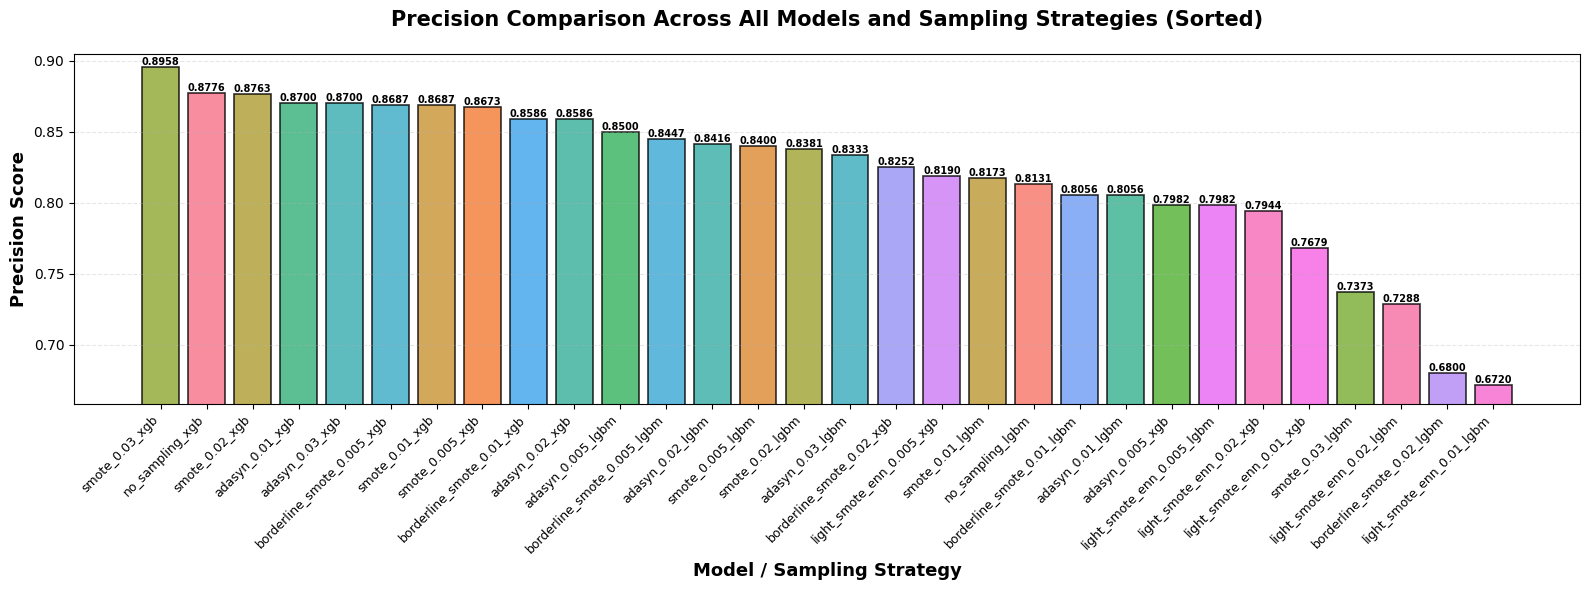

In [ ]:
plt.figure(figsize=(16, 6))
sorted_indices_precision = np.argsort(precision_scores)[::-1]
sorted_models_precision = [models[i] for i in sorted_indices_precision]
sorted_precision = [precision_scores[i] for i in sorted_indices_precision]
colors_precision = [sns.color_palette("husl", len(models))[i] for i in sorted_indices_precision]

bars2 = plt.bar(range(len(sorted_models_precision)), sorted_precision, color=colors_precision, alpha=0.8, edgecolor='black', linewidth=1.2)
plt.xlabel('Model / Sampling Strategy', fontsize=13, fontweight='bold')
plt.ylabel('Precision Score', fontsize=13, fontweight='bold')
plt.title('Precision Comparison Across All Models and Sampling Strategies (Sorted)', fontsize=15, fontweight='bold', pad=20)
plt.xticks(range(len(sorted_models_precision)), sorted_models_precision, rotation=45, ha='right', fontsize=9)
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.ylim([min(sorted_precision) * 0.98, max(sorted_precision) * 1.01])

# Add value labels
for i, (bar, score) in enumerate(zip(bars2, sorted_precision)):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{score:.4f}',
             ha='center', va='bottom', fontsize=7, fontweight='bold')

plt.tight_layout()
plt.show()

### Recall Analysis

**Recall = TP / (TP + FN)**

High recall indicates:
- Most actual fraud cases are detected
- Lower financial losses
- Potentially more false positives

**Practical Application**: Missing fraud cases costs money and damage reputation.

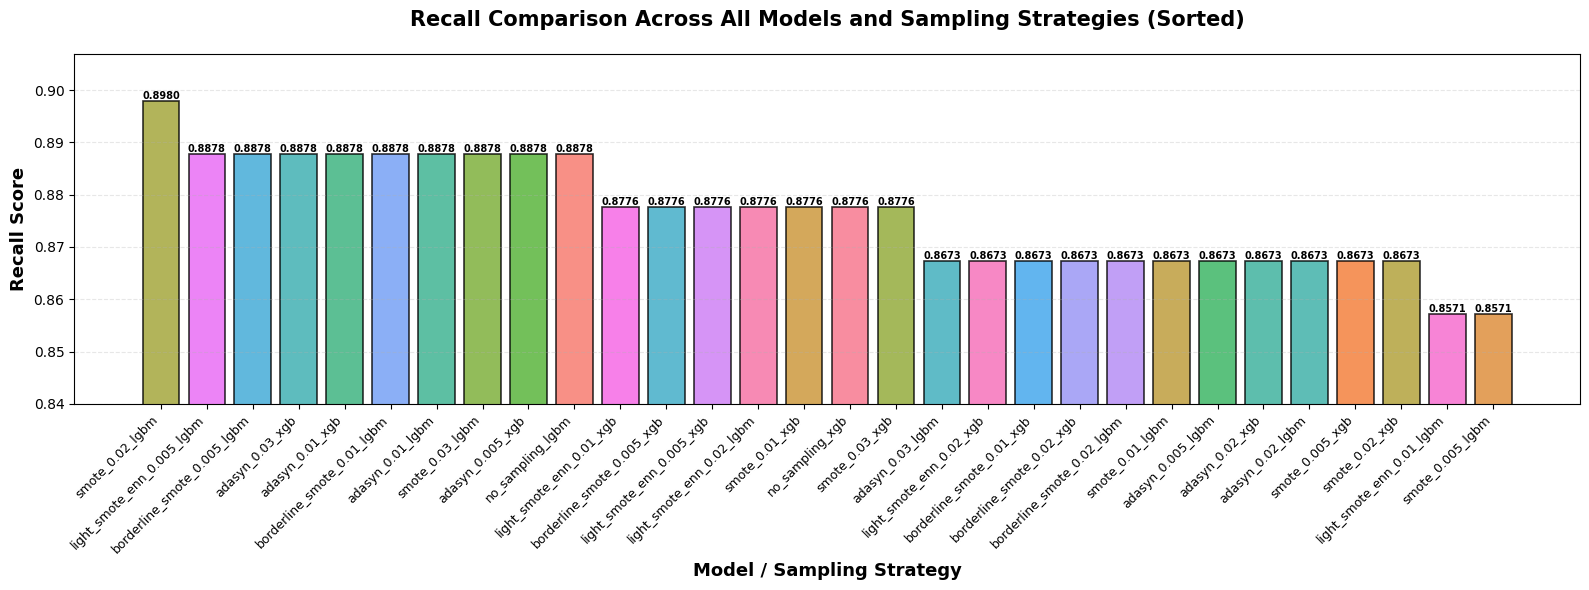

In [ ]:
plt.figure(figsize=(16, 6))
sorted_indices_recall = np.argsort(recall_scores)[::-1]
sorted_models_recall = [models[i] for i in sorted_indices_recall]
sorted_recall = [recall_scores[i] for i in sorted_indices_recall]
colors_recall = [sns.color_palette("husl", len(models))[i] for i in sorted_indices_recall]

bars3 = plt.bar(range(len(sorted_models_recall)), sorted_recall, color=colors_recall, alpha=0.8, edgecolor='black', linewidth=1.2)
plt.xlabel('Model / Sampling Strategy', fontsize=13, fontweight='bold')
plt.ylabel('Recall Score', fontsize=13, fontweight='bold')
plt.title('Recall Comparison Across All Models and Sampling Strategies (Sorted)', fontsize=15, fontweight='bold', pad=20)
plt.xticks(range(len(sorted_models_recall)), sorted_models_recall, rotation=45, ha='right', fontsize=9)
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.ylim([min(sorted_recall) * 0.98, max(sorted_recall) * 1.01])

# Add value labels
for i, (bar, score) in enumerate(zip(bars3, sorted_recall)):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{score:.4f}',
             ha='center', va='bottom', fontsize=7, fontweight='bold')

plt.tight_layout()
plt.show()

### Final Summary and Recommendations

Comparing all models across all metrics to identify:
1. **Best overall model** (highest AUPRC)
2. **Best precision model** (minimise false positives)
3. **Best recall model** (maximise fraud detection)

**Key insights from results**:
- SMOTE with 2-3% ratio performs best on XGBoost
- No-sampling baseline is already competitive (approximately 0.896 AUPRC)
- SMOTE-ENN significantly reduces precision
- XGBoost consistently outperforms LightGBM
- Borderline SMOTE shows promising results

In [11]:
best_auprc_idx = np.argmax(auprc_scores)
best_precision_idx = np.argmax(precision_scores)
best_recall_idx = np.argmax(recall_scores)

print(f"\nBest AUPRC: {models[best_auprc_idx]} = {auprc_scores[best_auprc_idx]:.4f}")
print(f"Best Precision: {models[best_precision_idx]} = {precision_scores[best_precision_idx]:.4f}")
print(f"Best Recall: {models[best_recall_idx]} = {recall_scores[best_recall_idx]:.4f}")


Best AUPRC: smote_0.02_xgb = 0.9020
Best Precision: smote_0.03_xgb = 0.8958
Best Recall: smote_0.02_lgbm = 0.8980


# References
Andrea Dal Pozzolo, Olivier Caelen, Reid A. Johnson and Gianluca Bontempi. Calibrating Probability with Undersampling for Unbalanced Classification. In Symposium on Computational Intelligence and Data Mining (CIDM), IEEE, 2015

Dal Pozzolo, Andrea; Caelen, Olivier; Le Borgne, Yann-Ael; Waterschoot, Serge; Bontempi, Gianluca. Learned lessons in credit card fraud detection from a practitioner perspective, Expert systems with applications,41,10,4915-4928,2014, Pergamon

Dal Pozzolo, Andrea; Boracchi, Giacomo; Caelen, Olivier; Alippi, Cesare; Bontempi, Gianluca. Credit card fraud detection: a realistic modeling and a novel learning strategy, IEEE transactions on neural networks and learning systems,29,8,3784-3797,2018,IEEE

Dal Pozzolo, Andrea Adaptive Machine learning for credit card fraud detection ULB MLG PhD thesis (supervised by G. Bontempi)

Carcillo, Fabrizio; Dal Pozzolo, Andrea; Le Borgne, Yann-Aël; Caelen, Olivier; Mazzer, Yannis; Bontempi, Gianluca. Scarff: a scalable framework for streaming credit card fraud detection with Spark, Information fusion,41, 182-194,2018,Elsevier

Carcillo, Fabrizio; Le Borgne, Yann-Aël; Caelen, Olivier; Bontempi, Gianluca. Streaming active learning strategies for real-life credit card fraud detection: assessment and visualization, International Journal of Data Science and Analytics, 5,4,285-300,2018,Springer International Publishing

Bertrand Lebichot, Yann-Aël Le Borgne, Liyun He, Frederic Oblé, Gianluca Bontempi Deep-Learning Domain Adaptation Techniques for Credit Cards Fraud Detection, INNSBDDL 2019: Recent Advances in Big Data and Deep Learning, pp 78-88, 2019

Fabrizio Carcillo, Yann-Aël Le Borgne, Olivier Caelen, Frederic Oblé, Gianluca Bontempi Combining Unsupervised and Supervised Learning in Credit Card Fraud Detection Information Sciences, 2019

Yann-Aël Le Borgne, Gianluca Bontempi Reproducible machine Learning for Credit Card Fraud Detection - Practical Handbook

Bertrand Lebichot, Gianmarco Paldino, Wissam Siblini, Liyun He, Frederic Oblé, Gianluca Bontempi Incremental learning strategies for credit cards fraud detection, IInternational Journal of Data Science and Analytics